In [36]:
import os
from pathlib import Path
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

plt.style.use("ggplot")

In [37]:
class CFG:
    seed = 69
    is_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
    
    if is_kaggle:
        data_wd = Path('/kaggle', 'input', 'optiver-trading-at-the-close')
    else:
        data_wd = Path.home() / '.data' / 'optiver-trading-at-the-close'

In [38]:
train = pd.read_csv(CFG.data_wd / 'train.csv')
train.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [39]:
mask = ~train.target.isna()
X_train = train.loc[mask, :].drop(['row_id', "time_id"], axis=1).copy()
y_train = X_train.pop('target')

In [40]:
model = lgb.LGBMRegressor(
    random_state = CFG.seed, 
    objective = 'mae', 
    device_type = 'gpu'
)

model.fit(X_train, y_train)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3057
[LightGBM] [Info] Number of data points in the train set: 5237892, number of used features: 14
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 14 dense feature groups (79.92 MB) transferred to GPU in 0.029079 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.060201


LGBMRegressor(device_type='gpu', objective='mae', random_state=69)

In [41]:
mae = mean_absolute_error(model.predict(X_train), y_train)
print(f'Mean Absolute Error: {mae:,.2f}')

Mean Absolute Error: 6.29


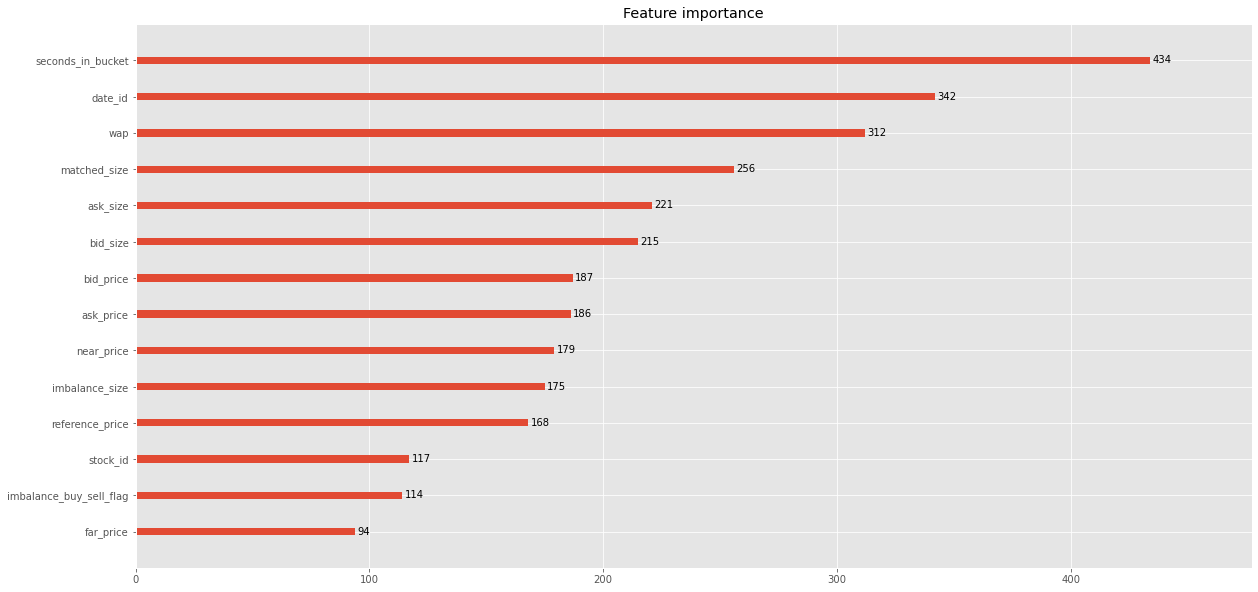

In [50]:
ax = lgb.plot_importance(
    model,
    figsize=(20, 10),
    xlabel='',
    ylabel='',
)
plt.show()

In [42]:
if CFG.is_kaggle:
    import optiver2023
    
    env = optiver2023.make_env()
    iter_test = env.iter_test()
    
    counter = 0
    for (test, revealed_targets, sample_prediction) in iter_test:
        sample_prediction['target'] = model.predict(test.drop(['row_id', 'currently_scored'], axis=1))
        env.predict(sample_prediction)
        counter += 1